In [197]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from datasets import load_dataset 
import numpy as np
from PIL import Image, ImageFilter
import os, random
import pandas as pd
import transformers as tr
import matplotlib.pyplot as plt
import json
import shutil
import copy

# DATA CLEANING

the first step is cleaning the data. for this, we create a dataframe from the JSON-LD file, then eliminate empty references to images in the DF while also deleting images that are not referenced in the DF. 

In [ ]:
# Converting the JSON-LD file in a DF
lines = []
with open("hateful_memes/train.jsonl") as f:
    lines = f.read().splitlines()

lines_dict = [json.loads(line) for line in lines]

df = pd.DataFrame(lines_dict)

In [ ]:
# Deleting all images not referenced in the dataset
imgs_referenced = df["img"]
imgs_referenced.astype(str)

def select_ref_imgs(orig_loc):
    orig_loc = str(orig_loc)
    file_name = orig_loc[4:]
   
    try:
        shutil.move(f"./hateful_memes/{orig_loc}", f"./hateful_memes/imgs_present/{file_name}")
        print(f"file {file_name} moved")
    except FileNotFoundError:
        print(f"file {file_name} not found")
        pass
    except Exception as e:
        print(f"error:{e}")

imgs_referenced.apply(select_ref_imgs)

In [ ]:
for file_name in os.listdir("./hateful_memes/img"):
    file_path = os.path.join("./hateful_memes/img", file_name)
    os.remove(file_path)
    print(f"{file_path} deleted.")

In [ ]:
shutil.rmtree("hateful_memes/img_old")

In [7]:
os.rename("hateful_memes/imgs_present", "hateful_memes/img")

In [ ]:
# Deleting empty references in the DataFrame
def check_imgs_exist(file_path):
    file_path = str(file_path)
    file_name = file_path[4:]
    if os.path.isfile(f"hateful_memes/{file_path}"):
        return True
    else:
        return False
    
reference_df = df
reference_df["img_exists"] = reference_df["img"].apply(check_imgs_exist)
reference_df = reference_df[reference_df["img_exists"]]
reference_df = reference_df.drop(columns=["img_exists"])
reference_df = reference_df.reset_index()

In [4]:
print(reference_df.head(), len(reference_df)) #checking the result

   index     id            img  label  \
0      0  42953  img/42953.png      0   
1      2  13894  img/13894.png      0   
2      4  82403  img/82403.png      0   
3      5  16952  img/16952.png      0   
4      6  76932  img/76932.png      0   

                                                text  
0   its their character not their color that matters  
1                           putting bows on your pet  
2  everybody loves chocolate chip cookies, even h...  
3           go sports! do the thing! win the points!  
4     fine you're right. now can we fucking drop it?   6744


In [ ]:
print(reference_df.query("id == '14507'")) #check on a query of a random image

     index     id            img  label  \
882   1112  14507  img/14507.png      1   

                                                  text  
882  when your history teacher starts talking about...  


In [15]:
# Saving the cleaned dataset as a CSV 
reference_df = reference_df.astype({"index":int, "id":int, "img":str, "label":float, "text":str})
data = reference_df

data.to_csv("data.csv")

This leaves us with a CSV file containing only "real" data and a folder with the images. the total instances remaining is 6744.

In [198]:
data = pd.read_csv("data.csv")
print (data.head())

   Unnamed: 0  index     id            img  label  \
0           0      0  42953  img/42953.png    0.0   
1           1      2  13894  img/13894.png    0.0   
2           2      4  82403  img/82403.png    0.0   
3           3      5  16952  img/16952.png    0.0   
4           4      6  76932  img/76932.png    0.0   

                                                text  
0   its their character not their color that matters  
1                           putting bows on your pet  
2  everybody loves chocolate chip cookies, even h...  
3           go sports! do the thing! win the points!  
4     fine you're right. now can we fucking drop it?  


# Fine-tuning 
Afterwards, two classes datasets and respective dataloaders are created. One for text-only data and the other one for images: these will serve the purpose of fine-tuning the HateBERT and ResNet models, on which the final model relies on.

## splitting the data
for splitting the data, we have to account for the following tasks:
- fine-tuning HateBERT and ResNet (with further subdivision for training and validation).
- training and validation (more on that later) for our final model.
- testing the model.
The percentages chosen were 25%, 68% ad 7% respectively. we don't need to split the training and validation for our final model, though, since we rely on K-fold cross-validation. 


In [199]:
class DatasetTxt (Dataset):
    def __init__(self, df, tokenizer):
        super().__init__()
        self.df = df
        self.tokenizer = tokenizer

        self.text= df["text"].values
        self.label = df["label"].values

    def __len__(self):
        return len(self.df["label"])
    
    def __getitem__(self, index):
        text = self.text[index]
        label = self.label[index]

        encoding = self.tokenizer.encode_plus(text, add_special_tokens=True, return_token_type_ids=False,
            padding='longest', return_attention_mask=True, return_tensors='pt', truncation=True)

        return {"input_ids": encoding["input_ids"].flatten(), "attention_mask": encoding["attention_mask"].flatten(),
                "labels": t.tensor(label, dtype=t.long)}
        
class DatasetImg (Dataset):
    def __init__(self, df, img_dir):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

        self.img= df["img"].values
        self.label = df["label"].astype(int).values

    def __len__(self):
        return len(self.df["label"])
    
    def __getitem__(self, index):
        img_pth = os.path.join(self.img_dir, self.img[index])
        img = Image.open(img_pth).convert("RGB")
        img_tensor = self.transform(img).unsqueeze(0)
        img_tensor = img_tensor.squeeze(1)
        label = self.label[index]

        return img_tensor, label



In [201]:
# splitting data: 25% for fine-tuning of sub-models (of which, 20% for validation)

hb_and_rs, rest = train_test_split(data, test_size= 0.75)
fine_tuning_subm, validation_subm = train_test_split(hb_and_rs, test_size=0.2)

In [202]:
tokenizer = tr.BertTokenizer.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english", clean_up_tokenization_spaces=True)

In [203]:
text_ds = DatasetTxt(fine_tuning_subm, tokenizer=tokenizer)
text_ds_val = DatasetTxt(validation_subm, tokenizer=tokenizer)

In [204]:
imag_ds = DatasetImg(fine_tuning_subm, img_dir="hateful_memes/")
imag_ds_val = DatasetImg(validation_subm, img_dir="hateful_memes/")

In [205]:
d_collator = tr.DataCollatorWithPadding(tokenizer=tokenizer)

In [206]:
train_loader_txt = DataLoader(text_ds, batch_size=16, shuffle=True, collate_fn=d_collator)
train_loader_img = DataLoader(imag_ds, batch_size=16, shuffle=True)
loader_txt_val = DataLoader(text_ds, batch_size=16, shuffle=True, collate_fn=d_collator)
loader_img_val = DataLoader(imag_ds, batch_size=16, shuffle=True)

# THE MODEL
As mentioned in the report, the model leverages the HateBERT and ResNet-50 architectures to extract predictions on the unimodal classification task. Similarly to CatBert, the predictions are concatenated and a MLP is placed above. Let's break down the general pipeline.
## FORWARD
### Separate processing
- images and processed texts are fed to HB and RN.
- logits for both media are projected in a larger fully-connected layer, followed by a ReLu activation function and a dropout layer.
- the Fast Fourier Transform is applied to both the outputs of those hidden layers.
### Fusion
- the results are concatenated.
- the MLP composed of a hidden layer and the classifier (separated by a ReLU + dropout phase) predicts the final classes. 

## OTHER METHODS
- evaluate_subpart(): manages validation of HB and RN; called during the fine-tuning.
- fine_tune_subpart(): manages training.

In [210]:
class MultiFFTCat(nn.Module):
    def __init__(self, text_model, img_model, classes):
        super().__init__()
        self.text_model = text_model

        in_features_img = img_model.fc.in_features
        img_model.fc = nn.Linear(in_features_img, 2)
        self.img_model = img_model


        # architecture
        #ToxicBERT/HateBERT input
        self.textfc = nn.Sequential(nn.Linear(classes, 24), nn.ReLU(), nn.Dropout(0.3))
        #ResNet input
        self.imgfc = nn.Sequential(nn.Linear(classes, 24),nn.ReLU(), nn.Dropout(0.3))

        # Fusion and classification
        self.mlp = nn.Sequential(nn.Linear(48, 16), nn.ReLU(), nn.Dropout(0.3), nn.Linear(16, 2))

    def forward(self, tokenized_text, image):
        cloned_txt_model = copy.deepcopy(self.text_model)
        cloned_img_model = copy.deepcopy(self.img_model)

        if "labels" in tokenized_text.keys(): #check if the input has labels (model in training)
        
            toktext = tokenized_text["input_ids"]
            mask = tokenized_text["attention_mask"]
            labels = tokenized_text["labels"]

            logits_for_txt = cloned_txt_model(input_ids=toktext, attention_mask=mask, labels=labels).logits
        
        else: #otherwise, model in evaluation, labels not required
            toktext = tokenized_text["input_ids"]
            mask = tokenized_text["attention_mask"]

            logits_for_txt = cloned_txt_model(input_ids=toktext, attention_mask=mask).logits
        
        img_t = cloned_img_model(image)

        txt_proc = self.textfc(logits_for_txt)
        img_proc = self.imgfc(img_t)

        txt_fft = t.fft.fft(txt_proc).real
        img_fft = t.fft.fft(img_proc).real
        fusion = t.cat([txt_fft, img_fft], dim=1)
        logits = self.mlp(fusion)

        return logits

    def evaluate_subpart(self, dataloader_val, input_type):
        model = self.text_model if input_type == "txt" else self.img_model
        model.eval()

        val_loss = 0
        val_correct_preds = 0
        val_tot_elements = 0

        criterion = nn.CrossEntropyLoss()

        if input_type == "txt":
            with t.no_grad(): #validation
                for val_batch in dataloader_val:
                    val_toktext = val_batch["input_ids"]
                    val_mask = val_batch["attention_mask"]
                    val_label = val_batch["labels"]
                    
                    val_outputs = model(input_ids=val_toktext, attention_mask=val_mask, labels=val_label)

                    current_loss_val = val_outputs.loss

                    val_loss += current_loss_val.item()
                    val_logits = val_outputs.logits

                    val_pred = t.argmax(val_logits, -1)

                    val_correct_preds += t.sum(val_pred == val_label)
                    val_tot_elements += len(val_label)

        elif input_type == "img":
            with t.no_grad():
                for val_images, val_labels in dataloader_val:
                        
                    val_images = val_images.squeeze(1)

                    val_outputs = model(val_images)

                    current_loss_val = criterion(val_outputs.float(), val_labels)
                    val_loss += current_loss_val.item()
                                        
                    _, val_pred = t.max(val_outputs.data, 1)

                    val_correct_preds += t.sum(val_pred == val_labels)
                    val_tot_elements += len(val_labels)

        print(f"val loss: {val_loss/(len(dataloader_val)):.4f}, val accuracy: {100*val_correct_preds.float()/val_tot_elements:.2f}")


    def fine_tune_subpart(self, dataloader_train, dataloader_val,  input_type):
        model = self.text_model if input_type == "txt" else self.img_model

        train_loss = 0
        train_correct_preds = 0
        train_tot_elements = 0

        if input_type == "txt":
            optimizer_txt = optim.AdamW(model.parameters(), lr= 5e-5)
            scheduler = optim.lr_scheduler.StepLR(optimizer_txt, step_size=1, gamma=0.9)
        elif input_type == "img":
            criterion = nn.CrossEntropyLoss()
            optimizer_img = optim.Adam(model.fc.parameters(), lr=5e-5)

        for e in range(8):
            model.train()
            if input_type == "txt":
                for name, param in model.named_parameters():
                    if "classifier" not in name:
                        param.requires_grad = False

                for batch in dataloader_train:
                    toktext = batch["input_ids"]
                    mask = batch["attention_mask"]
                    labels = batch["labels"]

                    outputs = model(input_ids=toktext, attention_mask=mask, labels=labels)
                    
                    loss = outputs.loss
                    logits = outputs.logits

                    optimizer_txt.zero_grad()
                    loss.backward()

                    nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], max_norm=1.0) 

                    optimizer_txt.step()
                    scheduler.step()
                    train_loss += loss.item()

                    pred = t.argmax(logits, -1)
                    train_correct_preds += t.sum(pred == labels)
                    train_tot_elements += len(labels)
                    

            elif input_type == "img":
                for name, param in model.named_parameters():
                                if "fc" not in name:
                                    param.requires_grad = False

                for images, labels in dataloader_train:

                    images = images.squeeze(1)

                    optimizer_img.zero_grad()
                    outputs = model(images)
                    
                    loss = criterion(outputs.float(), labels)
                    loss.backward()

                    nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], max_norm=1.0) 

                    optimizer_img.step()
                    train_loss += loss.item()
                                        
                    _, pred = t.max(outputs.data, 1)
                    train_correct_preds += t.sum(pred == labels)
                    train_tot_elements += len(labels)
            
            else:
                print ("input_type must be either 'txt' or 'img'")
            
            print(f"epoch {e+1}/8", 
        f"train loss: {train_loss/(len(dataloader_train)*(e+1)):.4f}, train accuracy: {100*train_correct_preds/train_tot_elements:.2f}")
            self.evaluate_subpart(dataloader_val, input_type)   


In [211]:
model_txt = tr.AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english", num_labels = 2)
model_img = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

In [ ]:
hmc_model = MultiFFTCat(text_model=model_txt, img_model=model_img, classes=2)

In [213]:
hmc_model.fine_tune_subpart(train_loader_txt, loader_txt_val, "txt")

epoch 1/8 train loss: 0.7548, train accuracy: 68.18
val loss: 0.8178, val accuracy: 67.14
epoch 2/8 train loss: 0.7452, train accuracy: 68.51
val loss: 0.8267, val accuracy: 67.14
epoch 3/8 train loss: 0.7436, train accuracy: 68.37
val loss: 0.8158, val accuracy: 67.14
epoch 4/8 train loss: 0.7441, train accuracy: 68.27
val loss: 0.8276, val accuracy: 67.14
epoch 5/8 train loss: 0.7432, train accuracy: 68.18
val loss: 0.8258, val accuracy: 67.14
epoch 6/8 train loss: 0.7456, train accuracy: 68.08
val loss: 0.8189, val accuracy: 67.14
epoch 7/8 train loss: 0.7451, train accuracy: 67.86
val loss: 0.8337, val accuracy: 67.14
epoch 8/8 train loss: 0.7466, train accuracy: 67.76
val loss: 0.8232, val accuracy: 67.14


In [214]:
hmc_model.fine_tune_subpart(train_loader_img, loader_img_val, "img")

epoch 1/8 train loss: 0.6567, train accuracy: 63.13
val loss: 0.5742, val accuracy: 72.03
epoch 2/8 train loss: 0.6267, train accuracy: 66.06
val loss: 0.5627, val accuracy: 69.07
epoch 3/8 train loss: 0.6066, train accuracy: 67.75
val loss: 0.5052, val accuracy: 78.71
epoch 4/8 train loss: 0.5880, train accuracy: 69.40
val loss: 0.4804, val accuracy: 79.15
epoch 5/8 train loss: 0.5730, train accuracy: 70.46
val loss: 0.4613, val accuracy: 81.53
epoch 6/8 train loss: 0.5598, train accuracy: 71.62
val loss: 0.4429, val accuracy: 81.16
epoch 7/8 train loss: 0.5465, train accuracy: 72.63
val loss: 0.4284, val accuracy: 81.90
epoch 8/8 train loss: 0.5368, train accuracy: 73.44
val loss: 0.4103, val accuracy: 85.31


## DATASET FOR FINAL MODEL
This dataset manages processing of both images and texts.

In [215]:
class dataset_hmc (Dataset):
    def __init__(self, df, tokenizer, img_path):
        super().__init__()
        self.df = df
        self.tokenizer = tokenizer
        self.img_dir = img_path
        self.transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

        self.text= df["text"].values
        self.label = df["label"].values
        self.img = df["img"].values

    def __len__(self):
        return len(self.df["label"])
    
    def __getitem__(self, index):
        
        text = self.text[index]
        label = self.label[index]

        encoding = self.tokenizer.encode_plus(text, add_special_tokens=True, return_token_type_ids=False,
            padding='longest', return_attention_mask=True, return_tensors='pt', truncation=True)
        
        img_pth = os.path.join(self.img_dir, self.img[index])
        img = Image.open(img_pth).convert("RGB")
        img_tensor = self.transform(img).unsqueeze(0)
        img_tensor = img_tensor.squeeze(1)
        label = self.label[index]

        return {"input_ids": encoding["input_ids"].flatten(), 
                "attention_mask": encoding["attention_mask"].flatten(),
                "img_tensor": img_tensor,
                "labels": t.tensor(label, dtype=t.long),
            }

# K-FOLD CROSS-VALIDATION
this method was used due to scarcity of data. After the splitting, we are left with only 3540 instances.

In [ ]:
# 68% of the whole dataset for training the multimodal model. 7% for testing

train_hmc, test = train_test_split(rest, test_size=0.10)

# transformation into array of labels and data in preparation of K-fold cross-validation
train_hmc_labels = train_hmc["label"].tolist()
train_hmc_data = train_hmc[["img", "text"]].values.tolist()

train_hmc_labels = np.array(train_hmc_labels)
train_hmc_data = np.array(train_hmc_data)


In [217]:
test_ds_hmc = dataset_hmc(df=test, tokenizer=tokenizer, img_path="hateful_memes/")

In [218]:
test_dataloader_hmc = DataLoader(test_ds_hmc, batch_size=16, shuffle=True, collate_fn=d_collator)

In [181]:
def train_model(dataloader, class_weights):
    hmc_model.img_model.train()
    for name, param in hmc_model.img_model.named_parameters():
        if "fc" not in name:
            param.requires_grad = False

    hmc_model.text_model.train()
    for name, param in hmc_model.text_model.named_parameters():
        if "classifier" not in name:
            param.requires_grad = False

    for name, param in hmc_model.named_parameters():
        if not param.requires_grad and param.grad is not None:
            print(f"Warning: {name} has a gradient despite being frozen.")

    hmc_model.train()

    train_params = [{"params": [p for n, p in hmc_model.named_parameters() if p.requires_grad and not n.endswith("bias")],"weight_decay": 0.01,},
        {"params": [p for n, p in hmc_model.named_parameters() if p.requires_grad and n.endswith("bias")],"weight_decay": 0.0,}]

    total_loss = 0
    correct_preds = 0
    total_elements = 0

    loss_function = nn.CrossEntropyLoss(weight=class_weights)
    optimizer_general = t.optim.AdamW(train_params, lr=1e-4)

    for e in range(7):
        for batch in dataloader:
            
            text_data = {
            "input_ids": batch["input_ids"],
            "attention_mask": batch["attention_mask"],
            "labels": batch["labels"]
            }
            img = batch["img_tensor"]
            img_squeezed = img.squeeze(1)
            label = batch["labels"]

            outputs = hmc_model(text_data,img_squeezed)

            loss = loss_function(outputs, label)

            optimizer_general.zero_grad()
            loss.backward()
            optimizer_general.step()

            total_loss += loss.item()
            _, pred = t.max(outputs.data, 1)

            correct_preds += t.sum(pred == label)
            total_elements += len(label)

        print(f"epoch {e+1}/7", 
            f"loss: {total_loss/(len(dataloader)*(e+1)):.4f}, accuracy: {100*correct_preds/total_elements:.2f}")


In [179]:
weights = t.tensor([0.647, 0.353]) # using weights for loss function based on the proportion of labels

In [221]:
def eval_model(dataloader):
    hmc_model.text_model.eval()
    hmc_model.img_model.eval()
    hmc_model.eval()

    loss_function = nn.CrossEntropyLoss()

    n_batch = 0
    val_loss = 0
    val_correct = 0
    val_total_el = 0
    pred_prob_total =[]
    label_total = []
    with t.no_grad():

        for batch in dataloader:
            text_data_val = {
            "input_ids": batch["input_ids"],
            "attention_mask": batch["attention_mask"]
            }
            img_val = batch["img_tensor"]
            img_val = img_val.squeeze(1)
            label_val = batch["labels"]
            
            val_outputs = hmc_model(text_data_val,img_val)
            loss_val = loss_function(val_outputs, label_val)

            val_loss += loss_val.item()
            _, val_pred = t.max(val_outputs.data, 1)

            val_correct += t.sum(val_pred == label_val)
            val_total_el += len(label_val)

            pred_probs = t.softmax(val_outputs, dim=1)[:, 1]
            pred_prob_total.extend(pred_probs.numpy())
            label_total.extend(label_val.numpy())

            n_batch +=1
            
        fpr, tpr, thresholds = roc_curve(label_total, pred_prob_total)
        roc_auc_total = roc_auc_score(label_total, pred_prob_total)
        
        print(f"validation loss: {val_loss/len(dataloader):.4f}, validation accuracy: {100*val_correct/val_total_el:.2f}%, ROC-AUC score: {roc_auc_total:.2f}")
        
        plt.figure()
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc_total:.2f})')
        plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()


### K-flold cross-validation
Due to scarcity of dataset, k-fold cross-validation is used to maximize the learning possibility of the model. the hyperparameter for deciding the number of folds is set to 4, since higher values didn't result in a significant improvement. After every training on n-1 k-folds is completed, validation starts and outputs loss, accuracy and ROC-AUC score alongside the curve profile.

Starting cycle n. 1
Starting training...
epoch 1/7 loss: 0.6879, accuracy: 54.98
epoch 2/7 loss: 0.6261, accuracy: 59.87
epoch 3/7 loss: 0.6018, accuracy: 61.37
epoch 4/7 loss: 0.5878, accuracy: 62.54
epoch 5/7 loss: 0.5789, accuracy: 63.20
epoch 6/7 loss: 0.5730, accuracy: 63.56
epoch 7/7 loss: 0.5681, accuracy: 63.86
Starting Validation...
validation loss: 0.6328, validation accuracy: 67.29%, ROC-AUC score: 0.69


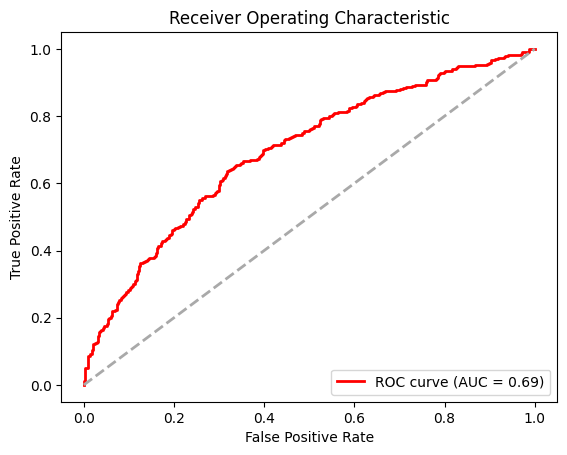

Starting cycle n. 2
Starting training...
epoch 1/7 loss: 0.5353, accuracy: 65.56
epoch 2/7 loss: 0.5395, accuracy: 65.63
epoch 3/7 loss: 0.5390, accuracy: 65.78
epoch 4/7 loss: 0.5387, accuracy: 65.90
epoch 5/7 loss: 0.5365, accuracy: 66.04
epoch 6/7 loss: 0.5349, accuracy: 66.05
epoch 7/7 loss: 0.5343, accuracy: 66.03
Starting Validation...
validation loss: 0.6445, validation accuracy: 68.50%, ROC-AUC score: 0.68


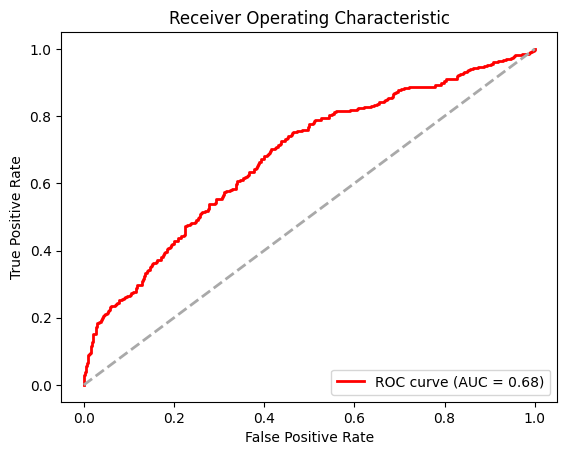

Starting cycle n. 3
Starting training...
epoch 1/7 loss: 0.5312, accuracy: 66.12
epoch 2/7 loss: 0.5342, accuracy: 65.76
epoch 3/7 loss: 0.5345, accuracy: 65.86
epoch 4/7 loss: 0.5347, accuracy: 65.90
epoch 5/7 loss: 0.5336, accuracy: 66.06
epoch 6/7 loss: 0.5336, accuracy: 66.11
epoch 7/7 loss: 0.5339, accuracy: 66.07
Starting Validation...
validation loss: 0.6220, validation accuracy: 67.58%, ROC-AUC score: 0.71


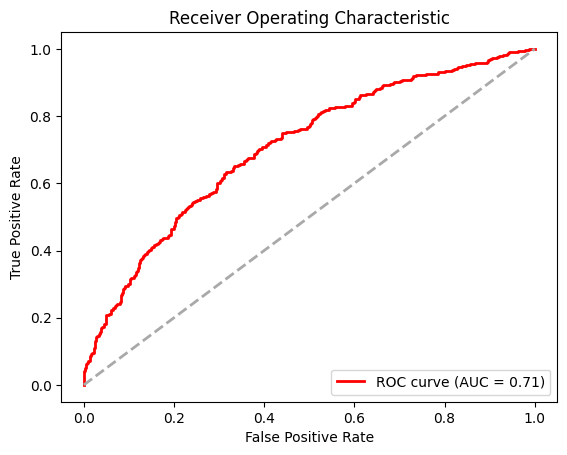

Starting cycle n. 4
Starting training...
epoch 1/7 loss: 0.5294, accuracy: 65.68
epoch 2/7 loss: 0.5306, accuracy: 65.84
epoch 3/7 loss: 0.5294, accuracy: 65.84
epoch 4/7 loss: 0.5296, accuracy: 65.83
epoch 5/7 loss: 0.5305, accuracy: 65.77
epoch 6/7 loss: 0.5301, accuracy: 65.77
epoch 7/7 loss: 0.5297, accuracy: 65.79
Starting Validation...
validation loss: 0.6439, validation accuracy: 68.57%, ROC-AUC score: 0.70


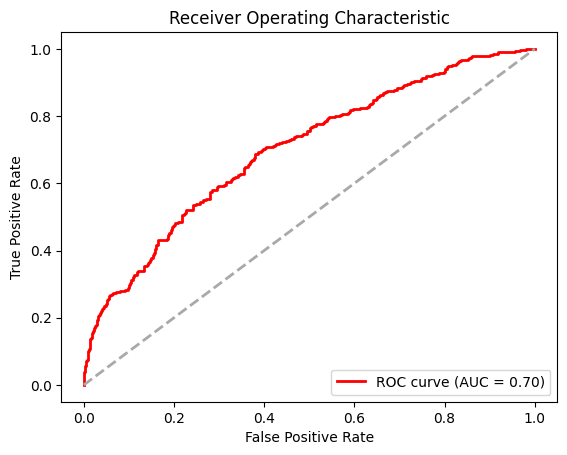

Starting cycle n. 5
Starting training...
epoch 1/7 loss: 0.5277, accuracy: 65.84
epoch 2/7 loss: 0.5291, accuracy: 65.91
epoch 3/7 loss: 0.5262, accuracy: 66.12
epoch 4/7 loss: 0.5273, accuracy: 66.17
epoch 5/7 loss: 0.5274, accuracy: 66.21
epoch 6/7 loss: 0.5270, accuracy: 66.24
epoch 7/7 loss: 0.5272, accuracy: 66.25
Starting Validation...
validation loss: 0.6522, validation accuracy: 66.92%, ROC-AUC score: 0.68


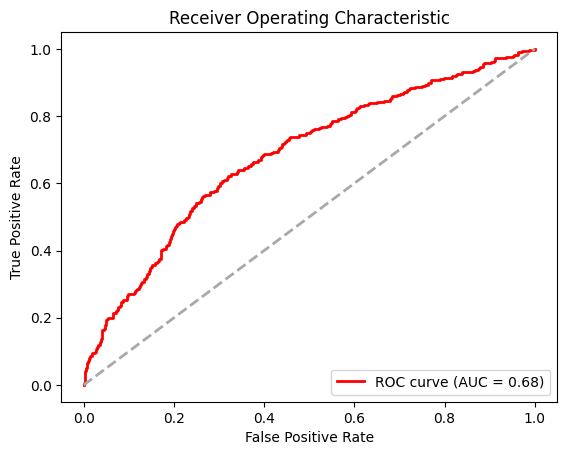

In [222]:
#we use K-fold cross-validation due to limited dataset

kfold = StratifiedKFold(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_hmc_data, train_hmc_labels)):
    print(f"Starting cycle n. {fold+1}")

    #training
    print("Starting training...")
    tdata = [train_hmc_data[i] for i in train_idx]
    tlabels = [train_hmc_labels[i] for i in train_idx]

    train_data_df = pd.DataFrame(tdata, columns=["img", "text"])
    train_data_df["label"] = tlabels

    train_ds = dataset_hmc(df=train_data_df, tokenizer=tokenizer, img_path="hateful_memes/")
    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=d_collator)

    train_model(train_dl, weights)

    #Validation
    print("Starting Validation...")
    vdata = [train_hmc_data[i] for i in val_idx]
    vlabels = [train_hmc_labels[i] for i in val_idx]
    
    val_data_df = pd.DataFrame(vdata, columns=["img", "text"])
    val_data_df["label"] = vlabels

    val_ds = dataset_hmc(df=val_data_df, tokenizer=tokenizer, img_path="hateful_memes/")
    val_dl = DataLoader(val_ds, batch_size=16, shuffle=True, collate_fn=d_collator)

    eval_model(val_dl)


# TEST

validation loss: 0.6009, validation accuracy: 69.37%, ROC-AUC score: 0.71


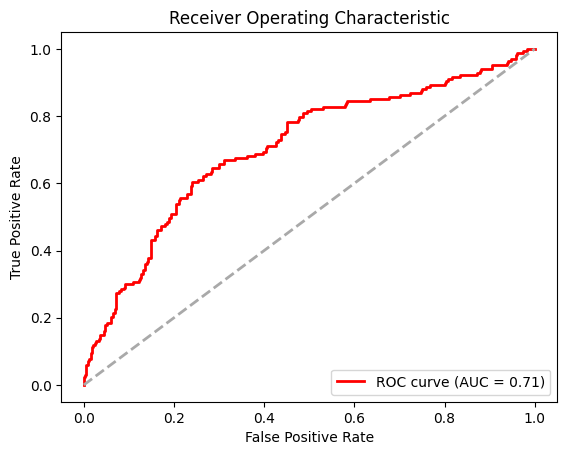

In [223]:
eval_model(test_dataloader_hmc)

## Censor function
This is just an idea on how to apply the model in censoring (and alerting) a meme whenever harmful content is detected

In [316]:
non_hateful_df = data.query("label == 0.0")
non_hateful_instance = non_hateful_df.head(1)

print(non_hateful_instance)

   Unnamed: 0  index     id            img  label  \
0           0      0  42953  img/42953.png    0.0   

                                               text  
0  its their character not their color that matters  


In [322]:
def alert(instance):
    ds = dataset_hmc(df=instance, tokenizer=tokenizer, img_path="hateful_memes/")
    dl = DataLoader(ds, batch_size=1, shuffle=True, collate_fn=d_collator)
    hmc_model.text_model.eval()
    hmc_model.img_model.eval()
    hmc_model.eval()
    for inst in dl:
        text_data = {
            "input_ids": inst["input_ids"],
            "attention_mask": inst["attention_mask"]
            }
        img = inst["img_tensor"]
        img = img.squeeze(1)
        img_path = os.path.join("hateful_memes/", instance["img"].item())
        
        outputs = hmc_model(text_data,img)
        sm = nn.Softmax(1)
        probs = sm(outputs.data)
        pred = t.argmax(outputs.data, 1)
        if pred == 1 and probs[0][1].item() > 0.60:
            img = Image.open(img_path).convert('RGB')

            im1 = img.filter(ImageFilter.BoxBlur(10))
            im1.show()
            print(f"This image was censored due to containing harmful content. Confidence:{probs[0][1].item()*100:.2f}%")
        else:
            print(f"This image doesn't seem to contain harmful content. Confidence:{probs[0][0].item()*100:.2f}%")

In [323]:
alert(non_hateful_instance)

This image doesn't seem to contain harmful content. Confidence:83.83%
